In [10]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc,roc_auc_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import nltk
import joblib
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Exploration et prétraitement des données

In [11]:
# Chargement des données 
data = pd.read_csv("tweets_suspect.csv")
data.head()
print("Répartition des classes :\n", data['label'].value_counts())

Répartition des classes :
 label
1    53855
0     6145
Name: count, dtype: int64


Nous avons 89.75% de données suspectes et 10.24% de données non suspectes. Cela traduit un déséquilibre très marqué entre les classes, toute chose qui pourrait biaisé les prédictions des données. Plusieurs techniques peuvent être envisagé pour surmonter cette limitation parmi lesquelles on note le sous-échantionnage. Cette technique préserve la qualité des données et réduit les biais mais reduit parcontre la quantité des données. Cependant, au regard de la quantité des données de la classe minoritaire l'impact du sous-échantillonnage pourrait être moindre. 

In [12]:
# Sous-echantillonnage
classMaj = data[data['label'] == 1]
classMin = data[data['label'] == 0]
classMajEchantillone = classMaj.sample(len(classMin), random_state=42)
equi_data = pd.concat([classMajEchantillone, classMin])
balanced_data = equi_data.sample(frac=1, random_state=42).reset_index(drop=True)
# Vérifier la nouvelle répartition des classes
print("Répartition des classes après sous-échantillonnage :\n", balanced_data['label'].value_counts())


Répartition des classes après sous-échantillonnage :
 label
1    6145
0    6145
Name: count, dtype: int64


In [13]:
balanced_data.head()

,message,label
0,"@etherjammer Oh, that's not cool.",1
1,@living3368 saw that on the news this morn! I...,1
2,@bhaalster new house mate has a punching bag,1
3,One last good sleep before getting back to rea...,0
4,@hello_jodie not listened to Kate Nash for age...,1


In [17]:
# Fonction de nettoyage des tweets
def nettoyage(data):
    data = re.sub(r"http\S+|www\S+|https\S+", '', data, flags=re.MULTILINE)  
    data = re.sub(r'\@\w+|\#', '', data)  
    data = re.sub(r"[^a-zA-Z\s]", '', data) 
    tokens = word_tokenize(data.lower())
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(cleaned_tokens)
# Appliquer le nettoyage
balanced_data['cleaned_message'] = balanced_data['message'].apply(nettoyage)
balanced_data.head()

# 2. Embeddings et représentation des données

In [15]:
# Vectorisation avec TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(balanced_data['cleaned_message'])
y = balanced_data['label']
# Sauvegarder le TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

# 3. Construction des modèles et gestion de l'équilibre des classes

In [45]:
# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.to_csv("X_train.csv")
# Définir les modèles
LogisticRegression = LogisticRegression(max_iter=1000)
RandomForest= RandomForestClassifier(random_state=42)
SVM = SVC(probability=True, random_state=42)


# 4. Modèles Traditionnels avec Grid Search + Cross Validation

In [29]:
# Paramètres de Grid Search pour chaque modèle
param_grid_logistic = {'C': [0.1, 1, 10]}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

In [30]:
# Définir les modèles avec Grid Search
logistic_grid = GridSearchCV(LogisticRegression, param_grid_logistic, cv=4, scoring='f1')
rf_grid = GridSearchCV(RandomForest, param_grid_rf, cv=4, scoring='f1')
svm_grid = GridSearchCV(SVM, param_grid_svm, cv=4, scoring='f1')


In [31]:
# Entraîner les modèles avec Grid Search
logistic_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)
svm_grid.fit(X_train, y_train)

# Meilleurs modèles après Grid Search
best_logistic = logistic_grid.best_estimator_
best_rf = rf_grid.best_estimator_
best_svm = svm_grid.best_estimator_

# Sauvegarder les modèles traditionnels
joblib.dump(best_logistic, 'best_logistic_model_v3.pkl')
joblib.dump(best_rf, 'best_rf_model_v3.pkl')
joblib.dump(best_svm, 'best_svm_model_v3.pkl')
print("Les modèles traditionnels ont été sauvegardés avec succès.")

Les modèles traditionnels ont été sauvegardés avec succès.


In [46]:
# Chargement des modèles
loaded_logistic = joblib.load('best_logistic_model_v3.pkl')
loaded_rf = joblib.load('best_rf_model_v3.pkl')
loaded_svm = joblib.load('best_svm_model_v3.pkl')
# Définir les modèles
models = {
    "LogisticRegression": loaded_logistic,
    "RandomForest": loaded_rf,
    "SVM": loaded_svm
}

Performance de LogisticRegression sur le test :
Accuracy: 0.8885272579332791
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88      1229
           1       0.86      0.93      0.89      1229

    accuracy                           0.89      2458
   macro avg       0.89      0.89      0.89      2458
weighted avg       0.89      0.89      0.89      2458

Matrice de Confusion:
 [[1037  192]
 [  82 1147]]
Performance de RandomForest sur le test :
Accuracy: 0.9068348250610252
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90      1229
           1       0.86      0.98      0.91      1229

    accuracy                           0.91      2458
   macro avg       0.92      0.91      0.91      2458
weighted avg       0.92      0.91      0.91      2458

Matrice de Confusion:
 [[1027  202]
 [  27 1202]]
Performance de SVM sur le test :
Accuracy: 0.89829

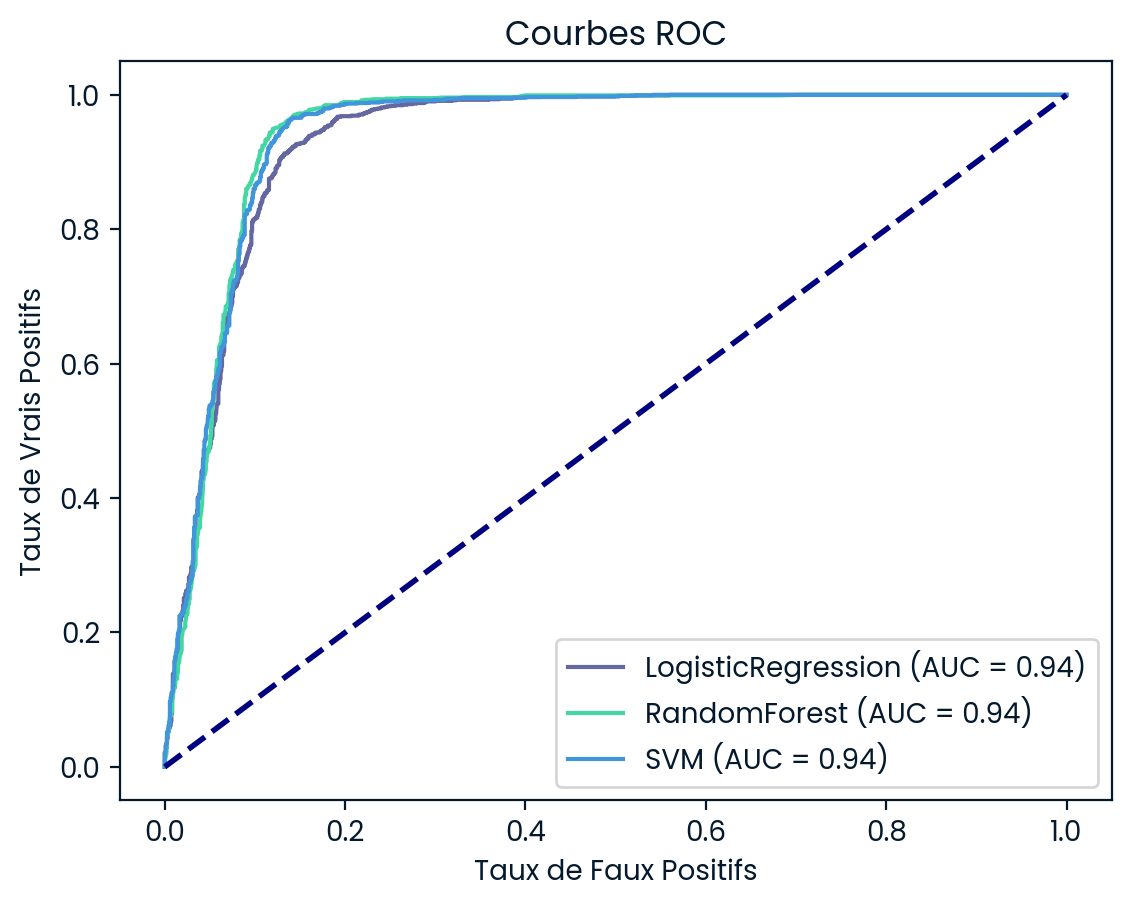

In [50]:
def evaluateModel(models, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        # Prédiction
        y_pred = model.predict(X_test)        
        # Évaluation des performances
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"Performance de {model_name} sur le test :")
        print(f"Accuracy: {accuracy}")
        print("Classification Report:\n", report)
        print("Matrice de Confusion:\n", conf_matrix)

        # Stocker les résultats
        results[model_name] = {
            "model": model,
            "accuracy": accuracy,
            "classification_report": report,
            "confusion_matrix": conf_matrix
        }

        # Courbe ROC
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbes ROC')
    plt.legend(loc="lower right")
    plt.show()

    return results

# Evaluation
results = evaluateModel(models, X_test, y_test)

# 5. Modèle pré-entraîné : BERT

## 5.1 Chargement des ressources

In [13]:
# Chargement des ressources
nltk.download('punkt')       # Tokenizer
nltk.download('stopwords')   # Stopwords list
nltk.download('wordnet')     # WordNet lemmatizer


# Tokenisation des données
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## 5.2 Tokenizer les textes

In [51]:
# Tokenizer les textes
X_train2, X_test2, y_train2, y_test2 = train_test_split(balanced_data['cleaned_message'], balanced_data['label'], test_size=0.2, random_state=42)

train_encodings = tokenizer(list(X_train2), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test2), truncation=True, padding=True, max_length=128)

## 5.3  Création de DataLoader pour PyTorch

In [53]:
# Création d'une classe Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Préparer les DataLoaders
batch_size = 32


train_dataset = TextDataset(X_train2, y_train2, tokenizer)
test_dataset = TextDataset(X_test2, y_test2, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 5.4 Fine-tuning du modèle BERT

In [16]:
# Chargement du modèle BERT pré-entraîné pour la classification binaire
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Optimiseur AdamW
optim = AdamW(model.parameters(), lr=5e-5)

# Définition du dispositif d'entraînement (GPU si disponible)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
# Fonction d'entraînement
def train(model, train_loader, scheduler=None):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optim.step()
        if scheduler:
            scheduler.step()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(train_loader)
    print(f'Average training loss: {avg_loss:.4f}')

In [19]:
# Fonction d'évaluation
def evaluate(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    y_proba = []
    total_eval_loss = 0
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            total_eval_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            true_labels += labels.cpu().numpy().tolist()
            predictions += preds.tolist()
            
            y_proba.extend(torch.nn.functional.softmax(logits, dim=1)[:, 1].cpu().numpy())
    
    avg_eval_loss = total_eval_loss / len(test_loader)
    print(f'Average evaluation loss: {avg_eval_loss:.4f}')
    
    # Calcul de la précision
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy:.4f}')
    
    # Rapport de classification
    report = classification_report(true_labels, predictions)
    print("Classification Report:\n", report)
    
    # Calcul de l'AUC
    auc_score = roc_auc_score(true_labels, y_proba)
    print(f'AUC: {auc_score:.4f}')
    
    # Calcul et affichage de la courbe ROC
    fpr, tpr, _ = roc_curve(true_labels, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'BERT (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()

    return predictions, true_labels

In [19]:
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)  
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Entraînement et évaluation sur plusieurs époques
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_loader, scheduler=scheduler) 
    print("-" * 50)

# Sauvegarder le modèle entraîné
model_save_path = "fine_tuned_bert_model.pt"
torch.save(model.state_dict(), model_save_path)
print(f"Modèle BERT sauvegardé sous : {model_save_path}")

Epoch 1/10
Batch 0/308, Loss: 0.6849
Batch 100/308, Loss: 0.2925
Batch 200/308, Loss: 0.4192
Batch 300/308, Loss: 0.1509
Average training loss: 0.3560
--------------------------------------------------
Epoch 2/10
Batch 0/308, Loss: 0.0257
Batch 100/308, Loss: 0.0565
Batch 200/308, Loss: 0.4020
Batch 300/308, Loss: 0.0529
Average training loss: 0.1507
--------------------------------------------------
Epoch 3/10
Batch 0/308, Loss: 0.0309
Batch 100/308, Loss: 0.0219
Batch 200/308, Loss: 0.0047
Batch 300/308, Loss: 0.0094
Average training loss: 0.0864
--------------------------------------------------
Epoch 4/10
Batch 0/308, Loss: 0.1938
Batch 100/308, Loss: 0.0034
Batch 200/308, Loss: 0.0029
Batch 300/308, Loss: 0.0030
Average training loss: 0.0461
--------------------------------------------------
Epoch 5/10
Batch 0/308, Loss: 0.0086
Batch 100/308, Loss: 0.0215
Batch 200/308, Loss: 0.2725
Batch 300/308, Loss: 0.0008
Average training loss: 0.0237
-----------------------------------------

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average evaluation loss: 0.4039
Accuracy: 0.9500
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1233
           1       0.95      0.95      0.95      1225

    accuracy                           0.95      2458
   macro avg       0.95      0.95      0.95      2458
weighted avg       0.95      0.95      0.95      2458

AUC: 0.9736


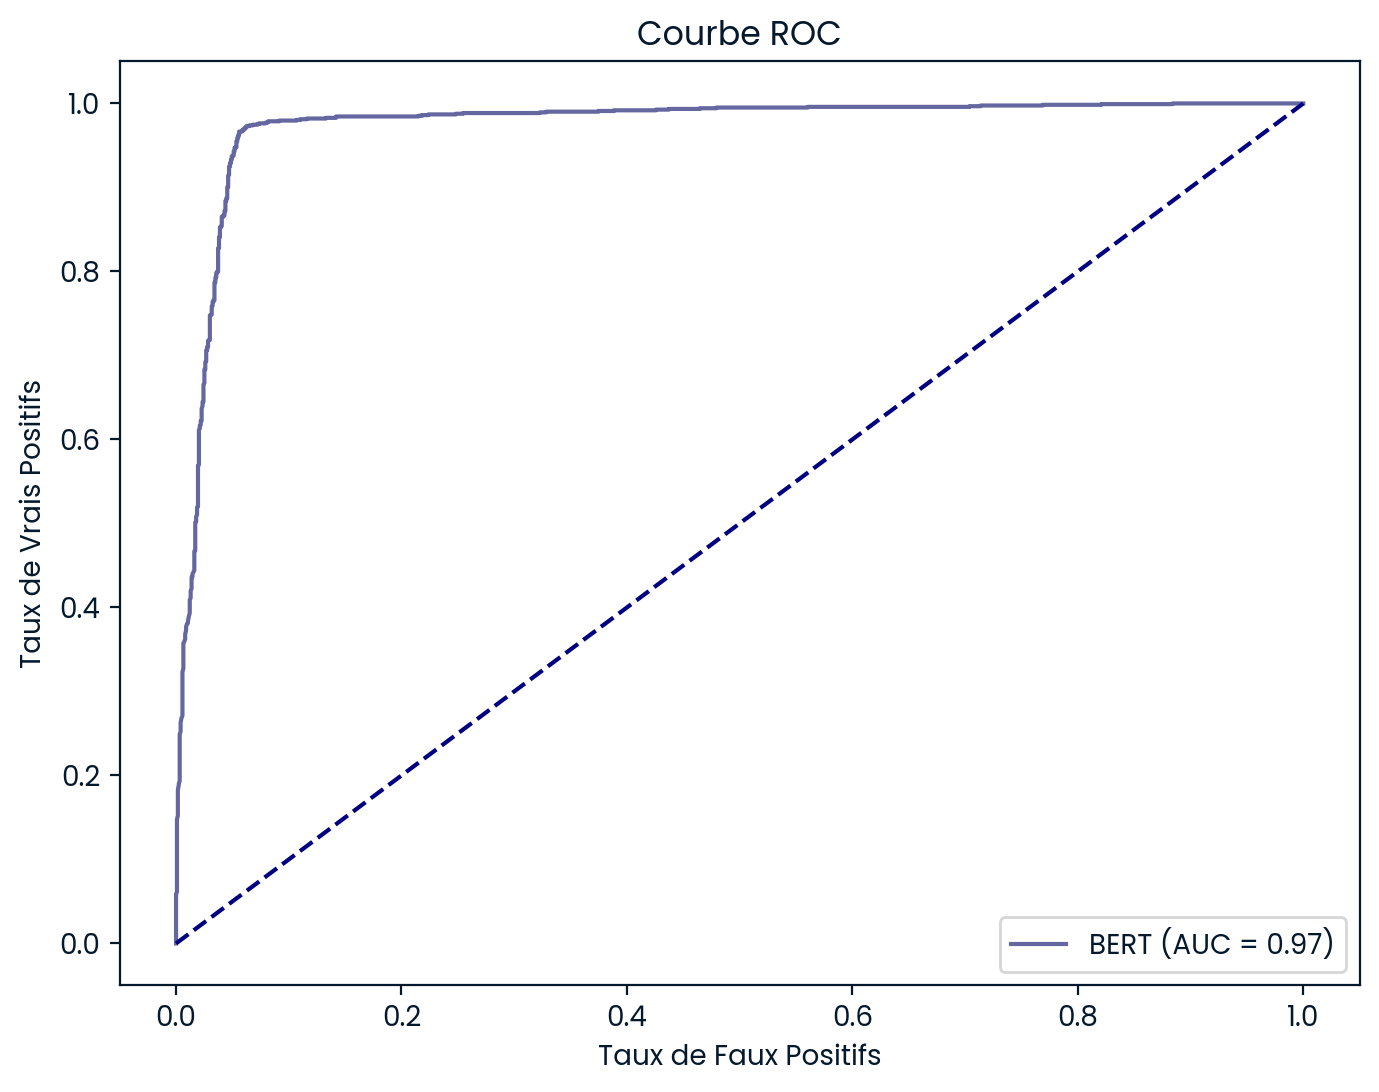

Accuracy: 0.9499593165174939
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1233
           1       0.95      0.95      0.95      1225

    accuracy                           0.95      2458
   macro avg       0.95      0.95      0.95      2458
weighted avg       0.95      0.95      0.95      2458



In [54]:
model_bert_loaded = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_bert_loaded.load_state_dict(torch.load('fine_tuned_bert_model.pt'))
model_bert_loaded = model_bert_loaded.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

y_pred, y_true = evaluate(model_bert_loaded, test_loader)

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# 6. Comparaison des modèles

In [21]:
# Charger les modèles sauvegardés
loaded_logistic = joblib.load('best_logistic_model_v3.pkl')
loaded_rf = joblib.load('best_rf_model_v3.pkl')
loaded_svm = joblib.load('best_svm_model_v3.pkl')
model_bert_loaded = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_bert_loaded.load_state_dict(torch.load('fine_tuned_bert_model.pt'))
model_bert_loaded = model_bert_loaded.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Vérification des modèles chargés
print(type(loaded_logistic))
print(type(loaded_rf))
print(type(loaded_svm))
print(type(model_bert_loaded))

<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.svm._classes.SVC'>
<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


In [23]:
def plot_roc_curves(models, X_test, y_test, test_loader, device, model_bert): 
    plt.figure(figsize=(10, 8))
    # Courbes ROC et métriques pour les modèles traditionnels
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)
        
        # Prédiction
        y_pred = model.predict(X_test)
        
        # Évaluation des performances
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"\nPerformance de {model_name} sur le test :")
        print(f"Accuracy: {accuracy:.2f}")
        print("Classification Report:\n", report)
        print("Matrice de Confusion:\n", conf_matrix)
        
        # Calcul des courbes ROC pour chaque modèle
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Courbe ROC et métriques pour BERT
    y_pred_proba = []
    y_true = []
    y_pred_labels = []

    model_bert.eval()
    with torch.no_grad():
        for d in test_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            
            outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)
            y_proba = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1]
            
            y_pred_proba.extend(y_proba.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_pred_labels.extend((y_proba > 0.2).int().cpu().numpy())  

    # Évaluation des performances pour BERT
    accuracy_bert = accuracy_score(y_true, y_pred_labels)
    report_bert = classification_report(y_true, y_pred_labels)
    conf_matrix_bert = confusion_matrix(y_true, y_pred_labels)

    print("\nPerformance de BERT sur le test :")
    print(f"Accuracy: {accuracy_bert:.2f}")
    print("Classification Report:\n", report_bert)
    print("Matrice de Confusion:\n", conf_matrix_bert)

    # Calcul de la courbe ROC pour BERT
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'BERT (AUC = {roc_auc:.2f})')

    # Personnalisation du graphique
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbes ROC')
    plt.legend(loc="lower right")
    plt.show()



Performance de Logistic Regression sur le test :
Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88      1229
           1       0.86      0.93      0.89      1229

    accuracy                           0.89      2458
   macro avg       0.89      0.89      0.89      2458
weighted avg       0.89      0.89      0.89      2458

Matrice de Confusion:
 [[1037  192]
 [  82 1147]]

Performance de Random Forest sur le test :
Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90      1229
           1       0.86      0.98      0.91      1229

    accuracy                           0.91      2458
   macro avg       0.92      0.91      0.91      2458
weighted avg       0.92      0.91      0.91      2458

Matrice de Confusion:
 [[1027  202]
 [  27 1202]]

Performance de SVM sur le test :
Accuracy: 0.90
Classification Report:
  

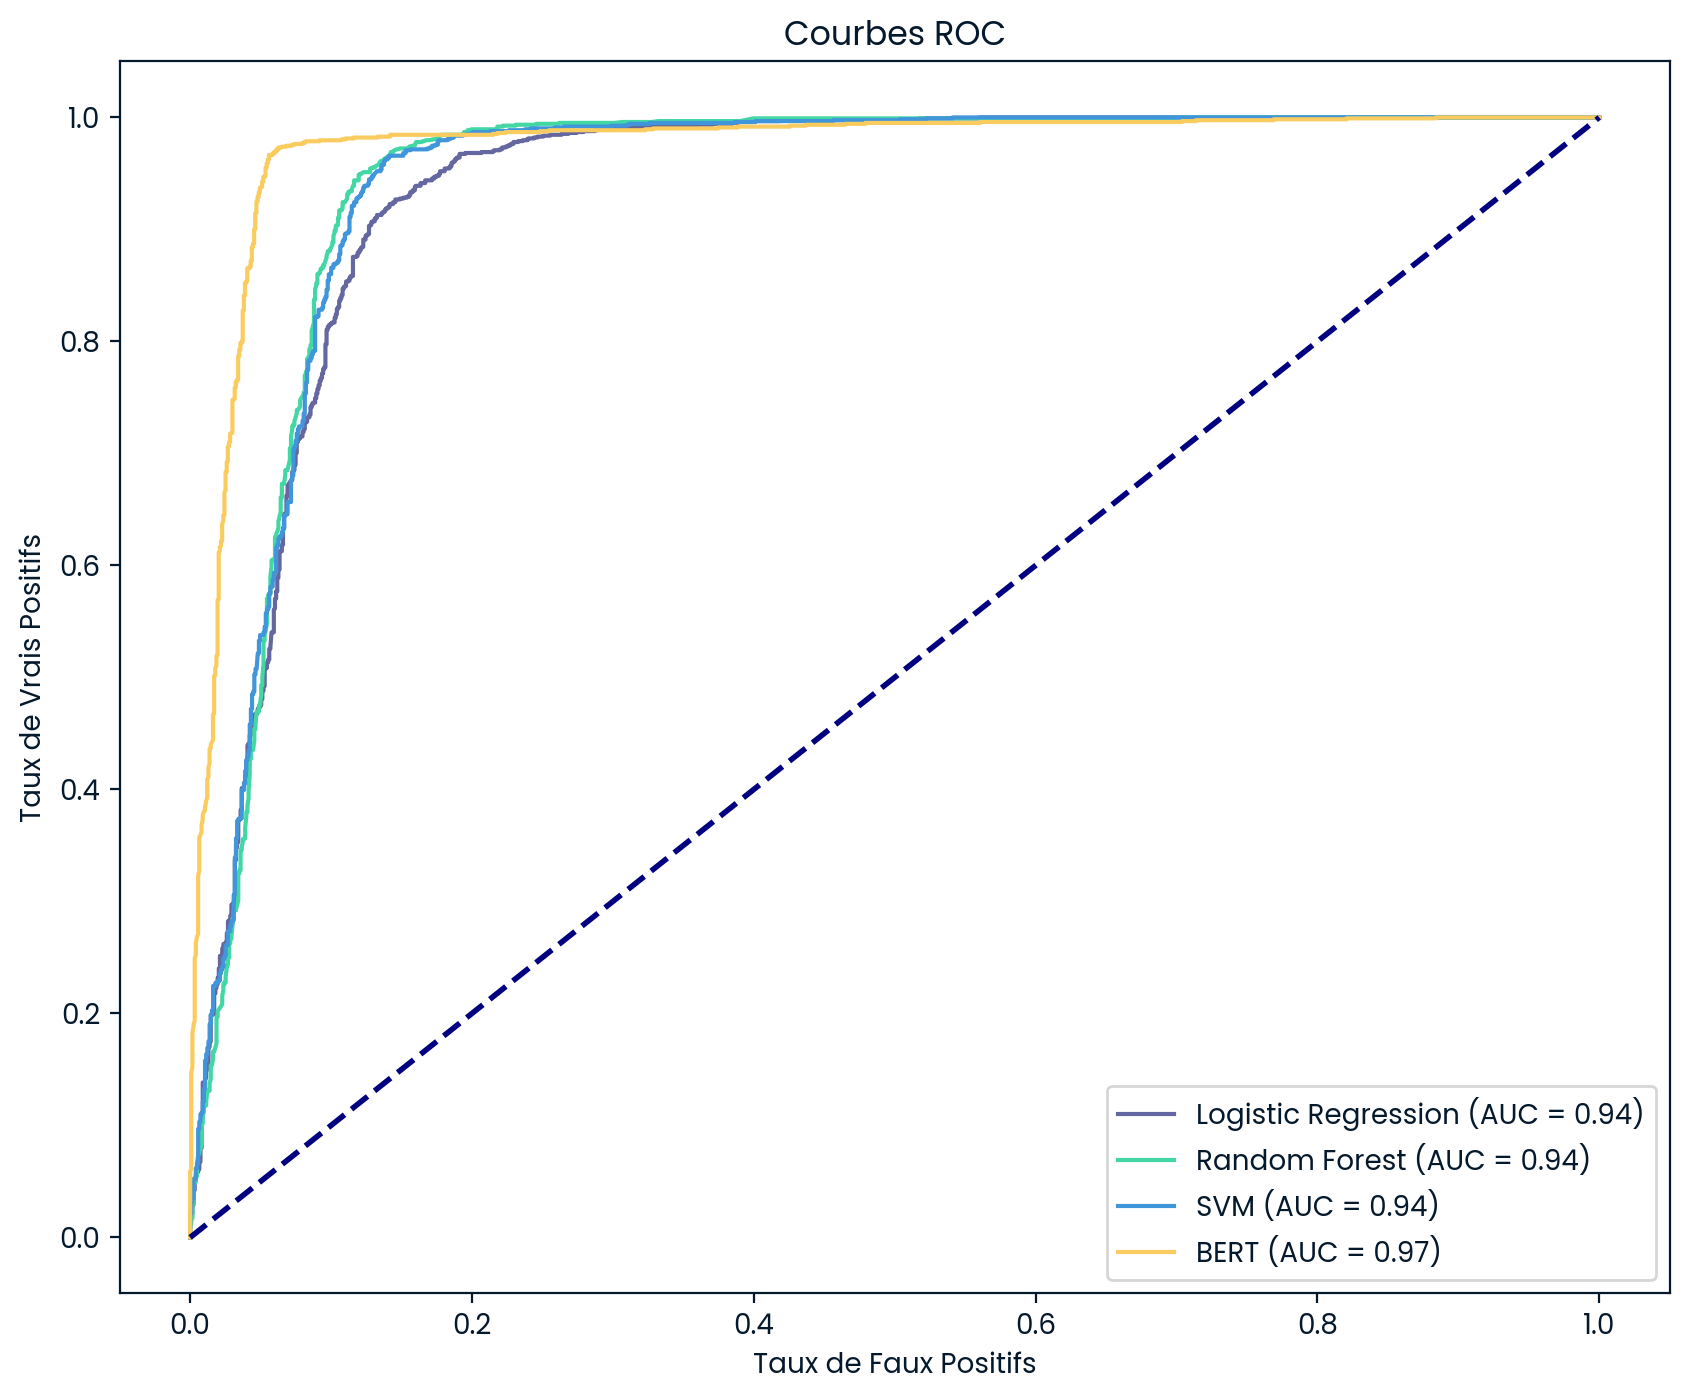

In [24]:
# Traçage des courbes ROC
plot_roc_curves(
    {"Logistic Regression": loaded_logistic, "Random Forest": loaded_rf, "SVM": loaded_svm},
    X_test, y_test, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"), model_bert_loaded
)
